In this notebook, we will examine various pieces of the Hartree-Fock algorithm and implement a simple restricted Hartree-Fock code for H2 molecules.

What we need to do here is fill the blank to understand the workflow.

This calculation is based on the cc-pvdz basis of the pyscf package. To reduce your workload, I generated the matrix and stored for your further calculation. If you are interest in using the pyscf package, please install the pyscf package and then run the matrix generation code below. Note that installing pyscf in Windows is kind of tricky and I would recommend to install pyscf through the Windows subsystem of linux (WSL).

Calculate the overlapping matrix S, the kinetic energy, potential energy and the four electron integral matrix using pyscf

In [1]:
# set up the H2 molecule 
# 如果想跑这一段程序，请在Linux/WSL系统中安装pyscf包
"""
import numpy as np
import scipy.linalg
from pyscf import gto


r=1.4
# Set up H2 molecular geometry and basis
mol = gto.M(
    atom = [['H', (0, 0, 0)],
            ['H', (r, 0, 0)]],
    basis = 'cc-pvdz', unit="bohr")

# Let's compute all the relevant gaussian integrals. We first compute
# the 1e integrals: overlap, electron-nuclear, and kinetic-energy integrals.
# The string codes for all the different integrals can be accessed by typing
# help(gto.moleintor.getints)
s=mol.intor("int1e_ovlp_sph")
t=mol.intor("int1e_kin_sph")
vne=mol.intor("int1e_nuc_sph")

nao = mol.nao_nr()
print("Total number of basis fns:", mol.nao_nr())
print(s.shape)
print(t.shape)
print(vne.shape)

# Let's now also compute the two-electron integrals
V=mol.intor("int2e_sph",aosym=1)
V=np.reshape(V,[nao,nao,nao,nao])

np.savetxt(
    'S_matrix',
    s)
np.savetxt(
    'T_matrix',
    t)
np.savetxt(
    'V_nuclei_matrix',
    vne)

np.savetxt(
    'V_matrix',
    V.flatten())
"""

'\nimport numpy as np\nimport scipy.linalg\nfrom pyscf import gto\n\n\nr=1.4\n# Set up H2 molecular geometry and basis\nmol = gto.M(\n    atom = [[\'H\', (0, 0, 0)],\n            [\'H\', (r, 0, 0)]],\n    basis = \'cc-pvdz\', unit="bohr")\n\n# Let\'s compute all the relevant gaussian integrals. We first compute\n# the 1e integrals: overlap, electron-nuclear, and kinetic-energy integrals.\n# The string codes for all the different integrals can be accessed by typing\n# help(gto.moleintor.getints)\ns=mol.intor("int1e_ovlp_sph")\nt=mol.intor("int1e_kin_sph")\nvne=mol.intor("int1e_nuc_sph")\n\nnao = mol.nao_nr()\nprint("Total number of basis fns:", mol.nao_nr())\nprint(s.shape)\nprint(t.shape)\nprint(vne.shape)\n\n# Let\'s now also compute the two-electron integrals\nV=mol.intor("int2e_sph",aosym=1)\nV=np.reshape(V,[nao,nao,nao,nao])\n\nnp.savetxt(\n    \'S_matrix\',\n    s)\nnp.savetxt(\n    \'T_matrix\',\n    t)\nnp.savetxt(\n    \'V_nuclei_matrix\',\n    vne)\n\nnp.savetxt(\n    \'V_matr

Going back to our normal process, using the matrix I previously generated. Here the system is a H2 molecules separated by 1.4 Bohr distance. What we do here is to solve the ground state many body equation to find the energy of thus configuration.

Here we are dealing with a specific type of basis function called cc-pvdz, which is very famous in the computational chemistry.

Load the overlapping matrix (S), kinetic energy matrix (T), the nuclei-electron energy (V_ne) and the two-electron intergal matrix (V). 

In [1]:
import numpy as np
from scipy.linalg import eig as Eig #用来计算广义特征值


S = np.loadtxt('S_matrix')
T = np.loadtxt('T_matrix')
V_ne = np.loadtxt('V_nuclei_matrix')
V = np.loadtxt('V_matrix').reshape([10,10,10,10]) # Using 5 basis function on one atom, so the total number of dimension is 10

(10, 10)


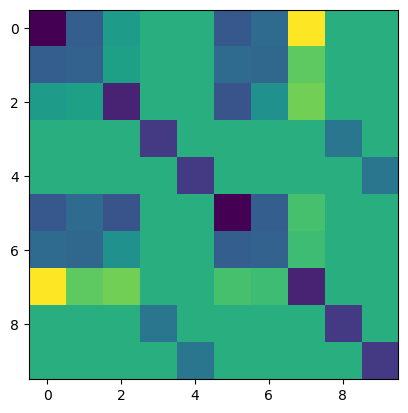

In [10]:
import matplotlib.pyplot as plt
plt.imshow(V_ne)
print(V_ne.shape)

There are many different conventions for the ordering of the indices of V. Here, it is defined as
$$ V_{ijkl} = \int \int d\mathbf{r_1} d\mathbf{r_2} \phi_i^*(\mathbf{r_1}) \phi_j(\mathbf{r_1}) \frac{1}{|\mathbf{r_1} - \mathbf{r_2}|}\phi_k^*(\mathbf{r_2}) \phi_l(\mathbf{r_2})$$
This is sometimes called the chemists' notation, and it is used because it allows Hartree-Fock programs to be written more efficiently using matrix multiplication. Note that it is different from the index ordering in lectures, which followed naturally from Dirac notation. One way to tell which ordering you are using is to inspect the $V_{0011}$ versus $V_{0101}$ element. If $V_{0011}>V_{0101}$ the integrals probably follow the chemists' convention, otherwise they likely follow the Dirac convention. 

In [3]:
# 查看各个矩阵的维度
print(S.shape)
print(T.shape)
print(V_ne.shape)
print(V.shape)

(10, 10)
(10, 10)
(10, 10)
(10, 10, 10, 10)


Here the number of basis function is 10 (2 atoms times 5 basis per atom). Thus the matrix we are dealing with is 10.

Now we are ready to see how restricted Hartree-Fock is implemented. Once the integrals are obtained, the restricted Hartree-Fock loop is as follows:
 - For the set of $M$ basis functions and $N$ electrons ($N$ even), write a function that builds the Fock matrix $\mathbf{f}$ from the density matrix $\mathbf{D}$ (both $M \times M$ matrices) following 
 $$\mathbf{f} = \mathbf{h} + \mathbf{J} + \mathbf{K}$$
 
 The one-electron Hamiltonian. (kinetic + nuclei potential energy)
 
 $$h_{pq} = t_{pq} + v_{pq}$$
 
 The Coulomb matrix, which can be calculated via the density matrix (密度矩阵)
  
 $$J_{pq} = \sum_{rs} D_{rs} V_{pqrs}$$
 
 The Exchange matrix.
 
 $$K_{pq} = -\frac{1}{2}\sum_{rs} D_{rs} V_{prqs}$$
 
 The expression here is a little bit different from the slides in the course. Does not matter at all!
 
 
 - Diagonalize the Fock matrix following $$ \mathbf{f} \mathbf{C} = \mathbf{S} \mathbf{C} \epsilon$$
 - build a new density matrix $\mathbf{D}$ with elements $$D_{pq} = 2 \sum_{i}^{N/2} C_{pi} C_{qi}$$
 - The N is number of electrons, 2 in our case, thus the sum over $i$ to $N/2$ means counting on all <font color=Red>occupied</font>
 states. This is to say that we at most have 10 states, but only $N/2$ is occuplied to build the Slatter Determinant.
 
 Fill in the code below to compute $\mathbf{J}$, $\mathbf{K}$, and $\mathbf{f}$ and Hartree-Fock energy. The restricted Hartree-Fock energy is
 $$E=\sum_{pq} h_{pq} D_{pq} + \sum_{pq} (J_{pq}+K_{pq}) D_{pq}$$
 
 The density matrix and Fock matrix diagonalization code is already provided.

Copy our eigenvalue solver here.

In [11]:
def Equation_solver(F,S):
    e_val,e_state = Eig(F,S) # 求解特征值 eigenvalue
    idx = e_val.argsort() #对特征值从小到大进行排列
    e_val = e_val[idx] #排列特征值
    e_state = e_state[:,idx] # 排列特征向量
    #下面计算归一化因子factor
    factor = 1/np.sqrt(np.einsum('pl,pq,ql -> l',e_state,S,e_state))
    e_state = factor*e_state
    
    e_val = np.real(e_val)
    return e_val,e_state #返回特征值与特征向量，这里特征值是各个态的能量

A trial computation.

In [13]:
nao = len(S) # Number of the atomic orbitals
nelec = 2 # Number of electron is 2 in H2 molecules

dm=np.ones([nao,nao]) # 对密度的初始猜测
J = np.einsum('rs,pqrs->pq',dm,V) # 计算J矩阵，库伦/Hartree项
K = -1/2*np.einsum('rs,prqs->pq',dm,V) #计算K，交换项, The only difference compared with the Hartree Calculation.
F = T + V_ne + J + K # h就是t和vne的部分，单电子积分
eigs,coeffs=Equation_solver(F,S)

#dm = np.zeros_like(F) # Initial Guess of The Density Matrix.
coeff_occupied = coeffs[:,:int(nelec/2)] # Only takes the oppupied state, (sum from 1 to N in the density calulation)
dm = 2 * np.einsum('pi,qi -> pq',coeff_occupied,coeff_occupied) # Calculate the updated density matrix

In [14]:
def cal_new_dm(dm): # 封装一下上述密度矩阵的迭代过程
    J = np.einsum('rs,pqrs->pq',dm,V)
    K = -1/2*np.einsum('rs,prqs->pq',dm,V)
    F = T + V_ne + J + K 
    eigs,coeffs=Equation_solver(F,S)
    coeff_occupied = coeffs[:,:int(nelec/2)] # Only takes the oppupied state, (sum from 1 to N in the density calulation)
    dm = 2 * np.einsum('pi,qi -> pq',coeff_occupied,coeff_occupied) # Calculate the updated density matrix
    return dm

def hf_energy(dm): # 能量计算器，输入密度矩阵，输出体系能量,参考上述公式
    J = np.einsum('rs,pqrs->pq',dm,V)
    K = -1/2*np.einsum('rs,prqs->pq',dm,V)
    E_1 = np.einsum('pq,pq',T + V_ne,dm)
    E_2 = np.einsum('pq,pq',J + K,dm)
    return E_1+E_2

In every iteration, we have new density matrix and total energy.

In [15]:
dm=np.zeros([nao,nao]) # 初始猜测
E= hf_energy(dm)
E_list = [E] # Save the first energy calculation

#迭代开始， scf过程
i = 1
while (i<20): # At most 20 iteration
    E_old = E
    dm = cal_new_dm(dm)
    E = hf_energy(dm)
    E_list.append(E)
    i = i + 1
    if abs(E-E_old)<1e-12:
        break

Text(0, 0.5, 'Energy (Hartree)')

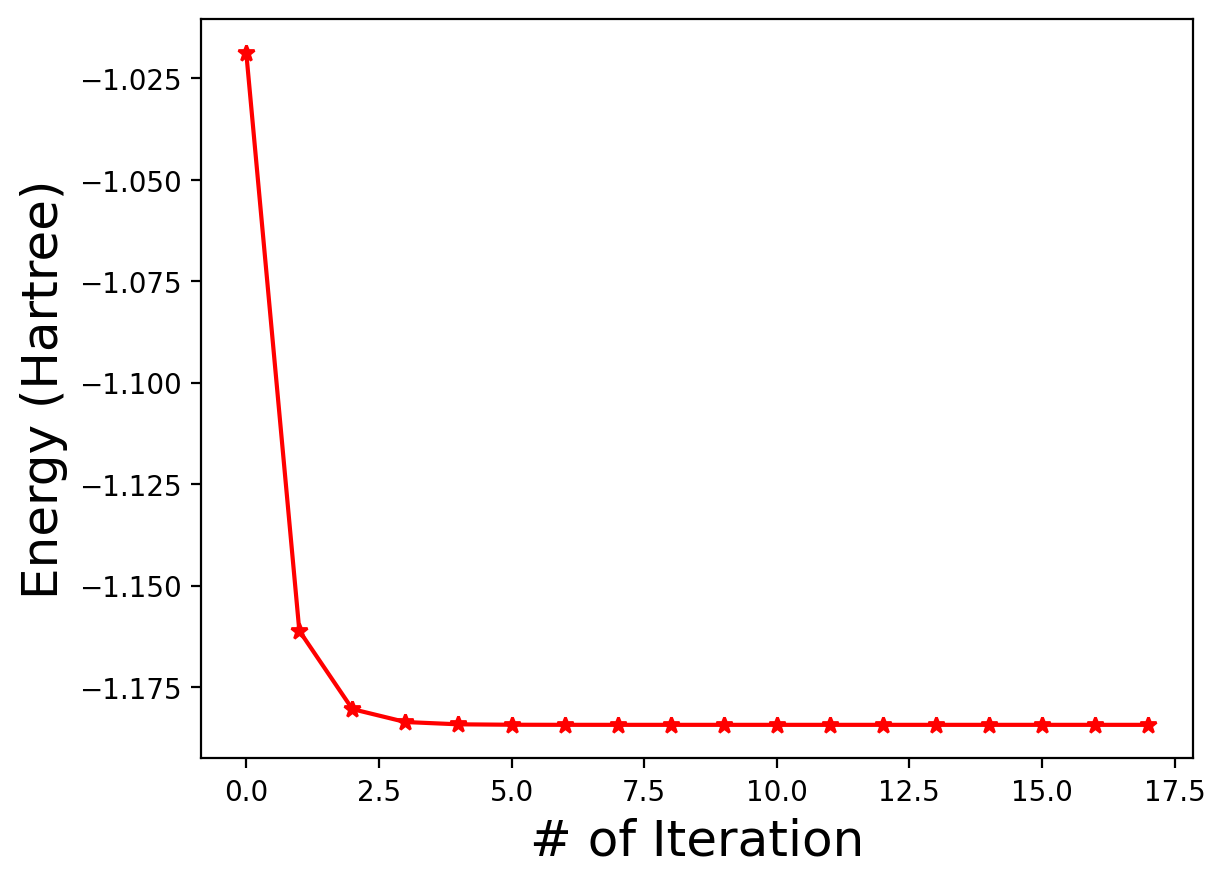

In [10]:
import matplotlib.pyplot as plt

plt.figure(dpi=200)
plt.plot(E_list[1:],'-*r')
plt.xlabel('# of Iteration',fontsize=18)
plt.ylabel('Energy (Hartree)',fontsize=18)

A summarized computation.

In [11]:
import numpy as np
from scipy.linalg import eig as Eig #用来计算广义特征值

# Load the matrix
S = np.loadtxt('S_matrix')
T = np.loadtxt('T_matrix')
V_ne = np.loadtxt('V_nuclei_matrix')
V = np.loadtxt('V_matrix').reshape([10,10,10,10])

# System setup
nao = len(S) 
nelec = 2 # Number of electron is 2 in H2 molecules

def Equation_solver(F,S):
    e_val = Eig(F,S)[0] # 求解特征值 eigenvalue
    e_state = Eig(F,S)[1] # 求解特征向量, 得到的其实是一个矩阵
    idx = e_val.argsort() #对特征值从小到大进行排列
    e_val = e_val[idx] #排列特征值
    e_state = e_state[:,idx] # 排列特征向量
    #下面计算归一化因子factor
    factor = 1/np.sqrt(np.einsum('pl,pq,ql -> l',e_state,S,e_state))
    e_state = factor*e_state
    e_val = np.real(e_val)
    return e_val,e_state #返回特征值与特征向量，这里特征值是各个态的能量

def cal_new_dm(dm):
    J = np.einsum('rs,pqrs->pq',dm,V)
    K = -1/2*np.einsum('rs,prqs->pq',dm,V)
    F = T + V_ne + J + K 
    eigs,coeffs=Equation_solver(F,S)
    coeff_occupied = coeffs[:,:int(nelec/2)] # Only takes the oppupied state, (sum from 1 to N in the density calulation)
    dm = 2 * np.einsum('pi,qi -> pq',coeff_occupied,coeff_occupied) # Calculate the updated density matrix
    return dm

def hf_energy(dm):
    J = np.einsum('rs,pqrs->pq',dm,V)
    K = -1/2*np.einsum('rs,prqs->pq',dm,V)
    E_1 = np.einsum('pq,pq',T + V_ne,dm)
    E_2 = np.einsum('pq,pq',J + K,dm)
    return E_1+E_2

dm=np.zeros([nao,nao]) # 初始猜测
E= hf_energy(dm)
E_list = [E] # Save the first energy calculation


#迭代开始， scf过程
i= 1
while (i<20): # At most 20 iteration
    E_old = E
    dm = cal_new_dm(dm)
    E = hf_energy(dm)
    E_list.append(E)
    i = i + 1
    if abs(E-E_old)<1e-12:
        break
        
print('The converged energy is {0:.4f} Hartree'.format(E_list[-1]))

The converged energy is -1.1843 Hartree
